# ALBERT for aptamer-pair classification

## Set dependancies

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import torch
import torch.nn as nn
import torch.onnx
import os
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
import random
import numpy as np
import pandas as pd
import ruamel.yaml
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
import transformers
import logging
transformers.logging.get_verbosity = lambda: logging.NOTSET

os.environ["TOKENIZERS_PARALLELISM"] = "false"
config_name = 'config.yaml'

## Load your dataset

In [3]:
with open(config_name, 'r') as stream:
    try:
        yaml = ruamel.yaml.YAML()
        config = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [4]:
path_to_train_data = config['Datasets']['train']
path_to_val_data = config['Datasets']['val']
path_to_test_data = config['Datasets']['test']


df_train = pd.read_csv(path_to_train_data)
df_val = pd.read_csv(path_to_val_data)
df_test = pd.read_csv(path_to_test_data)

In [5]:
print(df_train.shape, df_val.shape, df_test.shape)

(899400, 3) (112425, 3) (112425, 3)


In [6]:
df_train.head()

,Sequence1,Sequence2,Label
0,GCGGTAACCGGTGCT,GGAGAACAACAACTT,0
1,ATCAGATACTATGCG,TACAGAACTAGCAGG,0
2,AGAGTGCCCTGTCCC,ATCTGCTAACCAGTC,0
3,ATTCCCAAGCTGCGA,GTACCCGGGATGTTA,0
4,GCGAGCTCATGCACA,GGGCGCCATAGTTCG,0


## Classes and functions

In [7]:
class CustomDataset(Dataset):

    def __init__(self, data, maxlen, with_labels=True, bert_model='albert-base-v2'):
        self.data = data  # pandas dataframe
        self.tokenizer = AutoTokenizer.from_pretrained(bert_model, return_dict=False)  
        self.maxlen = maxlen
        self.with_labels = with_labels 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sent1 = str(self.data.loc[index, 'Sequence1'])
        sent2 = str(self.data.loc[index, 'Sequence2'])

        # Tokenize the pair of sentences to get token ids, attention masks and token type ids
        encoded_pair = self.tokenizer(sent1, sent2, 
                                      padding='max_length',  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=self.maxlen,  
                                      return_tensors='pt')  # Return torch.Tensor objects
        
        token_ids = encoded_pair['input_ids'].squeeze(0)  # tensor of token ids
        attn_masks = encoded_pair['attention_mask'].squeeze(0)  # binary tensor with "0" for padded values and "1" for the other values
        token_type_ids = encoded_pair['token_type_ids'].squeeze(0)  # binary tensor with "0" for the 1st sentence tokens & "1" for the 2nd sentence tokens

        if self.with_labels:  # True if the dataset has labels
            label = self.data.loc[index, 'Label']
            return token_ids, attn_masks, token_type_ids, label  
        else:
            return token_ids, attn_masks, token_type_ids

In [8]:
class Model(nn.Module):

    def __init__(self, bert_model="albert-base-v2", freeze_bert=False):
        super(Model, self).__init__()
        self.bert_layer = AutoModel.from_pretrained(bert_model, return_dict=False)

        #  Fix the hidden-state size of the encoder outputs
        #  More information can be found https://huggingface.co/transformers/pretrained_models.html
        hidden_size = config['Model']['hidden_size']

        # Freeze bert layers and only train the classification layer weights
        if freeze_bert:
            for p in self.bert_layer.parameters():
                p.requires_grad = False

        # Classification layer
        self.cls_layer = nn.Linear(hidden_size, config['Model']['number_labels'])
        self.dropout = nn.Dropout(p=config['Model']['dropout_rate'])

    @autocast()  # run in mixed precision
    def forward(self, input_ids, attn_masks, token_type_ids):
        '''
        Inputs:
            -input_ids : Tensor  containing token ids
            -attn_masks : Tensor containing attention masks to be used to focus on non-padded values
            -token_type_ids : Tensor containing token type ids to be used to identify sentence1 and sentence2
        '''

        # Feeding the inputs to the BERT-based model to obtain contextualized representations
        cont_reps, pooler_output = self.bert_layer(input_ids, attn_masks, token_type_ids)

        # Feeding to the classifier layer the last layer hidden-state of the [CLS] token further processed by a
        # Linear Layer and a Tanh activation. The Linear layer weights were trained from the sentence order prediction (ALBERT) or next sentence prediction (BERT)
        # objective during pre-training.
        logits = self.cls_layer(self.dropout(pooler_output))

        return logits

In [9]:
#seed to make results reproducible
def set_seed(seed):
    """ Set all seeds to make results reproducible """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    

def evaluate_loss(net, device, criterion, dataloader):
    net.eval()

    mean_loss = 0
    count = 0

    with torch.no_grad():
        for it, (seq, attn_masks, token_type_ids, labels) in enumerate(tqdm(dataloader)):
            seq, attn_masks, token_type_ids, labels = \
                seq.to(device), attn_masks.to(device), token_type_ids.to(device), labels.to(device)
            logits = net(seq, attn_masks, token_type_ids)
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            count += 1

    return mean_loss / count

In [10]:
def train_bert(net, criterion, opti, lr, lr_scheduler, train_loader, val_loader, epochs, iters_to_accumulate):

    best_loss = np.Inf
    nb_iterations = len(train_loader)
    print_every = nb_iterations // config['Random']['print_every']  # print the training loss 5 times per epoch
    scaler = GradScaler()
    
    iters = []
    train_losses = []
    val_losses = []

    for ep in range(epochs):

        net.train()
        running_loss = 0.0
        for it, (seq, attn_masks, token_type_ids, labels) in enumerate(tqdm(train_loader)):

            # Converting to cuda tensors
            seq, attn_masks, token_type_ids, labels = \
                seq.to(device), attn_masks.to(device), token_type_ids.to(device), labels.to(device)
    
            # Enables autocasting for the forward pass (model + loss)
            with autocast():
                # Obtaining the logits from the model
                logits = net(seq, attn_masks, token_type_ids)

                # Computing loss
                loss = criterion(logits.squeeze(-1), labels.float())
                loss = loss / iters_to_accumulate  # Normalize the loss because it is averaged

            # Backpropagating the gradients
            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            scaler.scale(loss).backward()

            if (it + 1) % iters_to_accumulate == 0:
                # Optimization step
                # scaler.step() first unscales the gradients of the optimizer's assigned params.
                # If these gradients do not contain infs or NaNs, opti.step() is then called,
                # otherwise, opti.step() is skipped.
                scaler.step(opti)
                # Updates the scale for next iteration.
                scaler.update()
                # Adjust the learning rate based on the number of iterations.
                lr_scheduler.step()
                # Clear gradients
                opti.zero_grad()


            running_loss += loss.item()

            if (it + 1) % print_every == 0:  # Print training loss information
                print()
                print("Iteration {}/{} of epoch {} complete. Loss : {} "
                      .format(it+1, nb_iterations, ep+1, running_loss / print_every))
                
                train_losses.append(running_loss)
                running_loss = 0.0


        val_loss = evaluate_loss(net, device, criterion, val_loader)  # Compute validation loss
        val_losses.append(val_loss)
        
        print()
        print("Epoch {} complete! Validation Loss : {}".format(ep+1, val_loss))

        if val_loss < best_loss:
            print("Best validation loss improved from {} to {}".format(best_loss, val_loss))
            print()
            net_copy = copy.deepcopy(net)  # save a copy of the model
            best_loss = val_loss
        
        
    
    # Saving the model
    path_to_model='model/{}_{}_{}.pt'.format(bert_model, lr, round(best_loss, 4))
    path_to_model_evaluation = './datasets/model_validation/{}_{}_{}.csv'.format(bert_model, lr, round(best_loss, 4))
    path_to_model_test = './datasets/model_validation/pred-{}_{}_{}.csv'.format(bert_model, lr, round(best_loss, 4))
    
    #  Following val/test losses to graph it later
    model_training = './datasets/model_validation/{}_{}_{}_training.csv'.format(bert_model, lr, round(best_loss, 4))
    losses = pd.DataFrame({'Train loss': train_losses, 'Val loss': val_losses})
    losses.to_csv(model_training)
    
    config['Random']['path_to_model'] = path_to_model
    config['Random']['path_to_model_evaluation'] = path_to_model_evaluation
    config['Random']['path_to_model_test'] = path_to_model_test

    torch.save(net_copy.state_dict(), path_to_model)
    print("The model has been saved in {}".format(path_to_model))

    del loss
    torch.cuda.empty_cache()

## Hyperparameters for training

In [11]:
bert_model = config['Model']['bert_model']  # any of previously defined BERT alternatives :'albert-base-v2', 'albert-large-v2', 'albert-xlarge-v2', 'albert-xxlarge-v2' and others
freeze_bert = config['Model']['freeze_bert']  # if True, freeze the encoder weights and only update the classification layer weights
maxlen = config['Model']['max_len']        # maximum length of the tokenized input sentence pair : if greater than "maxlen", the input is truncated and else if smaller, the input is padded
bs = config['Model']['batch_size']                # batch size
iters_to_accumulate = config['Model']['iters_to_accumulate']  # the gradient accumulation adds gradients over an effective batch of size : bs * iters_to_accumulate. If set to "1", you get the usual batch size
lr = config['Model']['learning_rate']                # learning rate
epochs = config['Model']['epochs']             # number of training epochs

nb_iterations = len(train_loader)## Training

In [18]:
#  Set all seeds to make reproducible results
set_seed(2)
 
# Creating instances of training and validation set
print("Reading training data...")
train_set = CustomDataset(df_train, maxlen, bert_model)
print("Reading validation data...")
val_set = CustomDataset(df_val, maxlen, bert_model)
# Creating instances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size=bs, num_workers=2)
val_loader = DataLoader(val_set, batch_size=bs, num_workers=2)
 
 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Model(bert_model, freeze_bert=freeze_bert)

if torch.cuda.device_count() > 1:  # if multiple GPUs
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)

net.to(device)
   
criterion = nn.BCEWithLogitsLoss()
opti = AdamW(net.parameters(), lr=lr, weight_decay=1e-2)
num_warmup_steps = config['Model']['num_warmup_steps'] # The number of steps for the warmup phase.
num_training_steps = epochs * len(train_loader)  # The total number of training steps
t_total = (len(train_loader) // iters_to_accumulate) * epochs  # Necessary to take into account Gradient accumulation
lr_scheduler = get_linear_schedule_with_warmup(optimizer=opti, num_warmup_steps=num_warmup_steps, num_training_steps=t_total)
                         
#train_bert(net, criterion, opti, lr, lr_scheduler, train_loader, val_loader, epochs, iters_to_accumulate)

with open('config.yaml', 'w') as conf:
    yaml.dump(config, conf)

Reading training data...
Reading validation data...


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Plot training losses

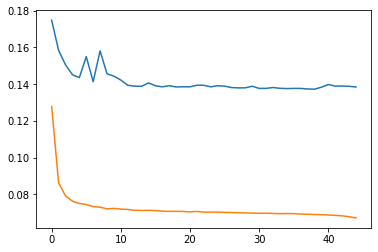

In [15]:
losses = pd.read_csv('./datasets/model_validation/albert-base-v2_5e-05_0.1372_training.csv')
plt.plot(losses[['Val loss','Train loss']][0:45])
plt.savefig("val-train.png") # save as png

# Prediction

In [25]:
#!kill -9 -1 #in case you have to kill the process

(1000, 3)

## Prediction

In [16]:
def get_probs_from_logits(logits):
    """
    Converts a tensor of logits into an array of probabilities by applying the sigmoid function
    """
    probs = torch.sigmoid(logits.unsqueeze(-1))
    return probs.detach().cpu().numpy()


def test_prediction(net, device, aptamerDataFrame, dataloader, with_labels, result_path=config['Random']['path_to_model_test']):
    """
    Predict the probabilities on a dataset with or without labels and print the result in a file
    """
    net.eval()
    probs_all = []
    nb_iterations = len(dataloader)
    
    with torch.no_grad():
        if with_labels:
            for it, (seq, attn_masks, token_type_ids, label) in enumerate(tqdm(dataloader)):
                seq, attn_masks, token_type_ids = seq.to(device), attn_masks.to(device), token_type_ids.to(device)
                logits = net(seq, attn_masks, token_type_ids)
                probs = get_probs_from_logits(logits.squeeze(-1)).squeeze(-1)
                probs_all += probs.tolist()
                
        else:
            for it, (seq, attn_masks, token_type_ids, token_ids) in enumerate(tqdm(dataloader)):
                seq, attn_masks, token_type_ids = seq.to(device), attn_masks.to(device), token_type_ids.to(device)
                logits = net(seq, attn_masks, token_type_ids)
                probs = get_probs_from_logits(logits.squeeze(-1)).squeeze(-1)
                probs_all += probs.tolist()
            
    y_hat = [round(x) for x in probs_all]     
    df2 = pd.DataFrame({'y_hat': y_hat, 'prob': probs_all})
    df = pd.concat([aptamerDataFrame, df2], axis=1)
    df.to_csv(result_path)


In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Reading test data...")
test_set = CustomDataset(df_test, maxlen, bert_model)
test_loader = DataLoader(test_set, batch_size=bs, num_workers=4)

model = Model(bert_model)
if torch.cuda.device_count() > 1:  # if multiple GPUs
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

print()
print("Loading the weights of the model...")
model.load_state_dict(torch.load(config['Random']['path_to_model']))
model.to(device)

print("Predicting on test data...")
test_prediction(net=model
                , device=device
                , dataloader=test_loader
                , aptamerDataFrame=df_test
                , with_labels = True)

print()
print("Predictions are available in : {}".format(config['Random']['path_to_model_test']))

Reading test data...


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Loading the weights of the model...
Predicting on test data...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1757/1757 [01:33<00:00, 18.81it/s]



Predictions are available in : ./datasets/model_validation/pred-albert-base-v2_5e-05_0.1075.csv


#  Model Metrics

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [21]:
df = pd.read_csv(config['Random']['path_to_model_test'])

accuracy = accuracy_score(df['Label'], df['y_hat'])
precision = precision_score(df['Label'], df['y_hat'])
recall = recall_score(df['Label'], df['y_hat'])
f1 = f1_score(df['Label'], df['y_hat'])
roc_auc = roc_auc_score(df['Label'], df['prob'])
matrix = confusion_matrix(df['Label'], df['y_hat'])

print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('f1: ', f1)
print('roc_auc: ', roc_auc)
print('matrix: \n', matrix)

accuracy:  0.972497220369135
precision:  0.9952591597140564
recall:  0.9494667117750752
f1:  0.9718237985018864
roc_auc:  0.9774729030292202
matrix: 
 [[56010   254]
 [ 2838 53323]]


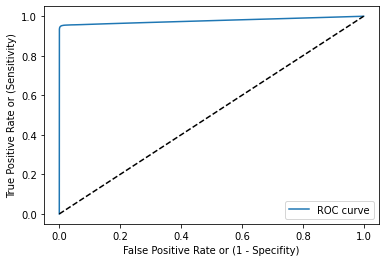

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

fpr,tpr,threshold = roc_curve(df['Label'], df['prob'])
roc_auc =auc(fpr, tpr)

plt.figure(frameon=False)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.legend(loc='lower right')


fig.savefig("ROC Curve.png", bbox_inches='tight', pad_inches=0, transparent=True)

#  Convert model to ONNX


In [18]:
if config['Model']['convert_to_onnx']:
    sequences = {'AGCTAAGCTAAGCTA':'AAGACTGACAGCTAA'}
    sequences=pd.DataFrame(sequences.items(), columns=['Sequence1', 'Sequence2'])
    dataset = CustomDataset(
        data = sequences,
        maxlen = config['Model']['max_len'],
        with_labels = False #sulyginti su class cusotmedatasets
        )
    
    model = Model(bert_model)
    
    model.load_state_dict(torch.load(config['Random']['path_to_model']))
    model.to(device)
    model.eval()
    #defining model inputs, which are ids, kmask and toke type ids (it comes from Model Class)
    input_ids= dataset[0][0].unsqueeze(0).cuda()
    attn_masks = dataset[0][0].unsqueeze(0).cuda()
    token_type_ids = dataset[0][0].unsqueeze(0).cuda()
        
    torch.onnx.export(
        model, #.module if paralized
        (input_ids, attn_masks, token_type_ids),
        "model.onnx",
        input_names=["input_ids", "attn_masks", "token_type_ids"], 
        output_names=["output"],
        #which inputs have dynamical axes
        verbose=True,
        dynamic_axes={
            "input_ids": {0: "batch_size"},
            "attn_masks": {0: "batch_size"},
            "token_type_ids": {0: "batch_size"},
            "output": {0: "batch_size"},
        },
        opset_version=10,
        )    

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.dense.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.